# Negative Volume Index (NVI)

https://www.investopedia.com/terms/n/nvi.asp

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# fix_yahoo_finance is used to fetch data 
import yfinance as yf
yf.pdr_override()

In [2]:
# input
symbol = 'AAPL'
start = '2020-01-01'
end = '2023-01-01'

# Read data 
df = yf.download(symbol,start,end)

# View Columns
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02 00:00:00-05:00,74.059998,75.150002,73.797501,75.087502,73.449394,135480400
2020-01-03 00:00:00-05:00,74.287498,75.144997,74.125000,74.357498,72.735321,146322800
2020-01-06 00:00:00-05:00,73.447502,74.989998,73.187500,74.949997,73.314888,118387200
2020-01-07 00:00:00-05:00,74.959999,75.224998,74.370003,74.597504,72.970100,108872000
2020-01-08 00:00:00-05:00,74.290001,76.110001,74.290001,75.797501,74.143890,132079200


In [3]:
returns = df['Adj Close'].pct_change()
vol_decrease = (df['Volume'].shift(1) > df['Volume'])

nvi = pd.Series(data=np.nan, index=df['Adj Close'].index, dtype='float64')

nvi.iloc[0] = 1000
for i in range(1,len(nvi)):
    if vol_decrease.iloc[i]:
        nvi.iloc[i] = nvi.iloc[i - 1] * (1.0 + returns.iloc[i])
    else:
        nvi.iloc[i] = nvi.iloc[i - 1]

nvi = nvi.replace([np.inf, -np.inf], np.nan).fillna(1000)

df['NVI'] = pd.Series(nvi)

In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,NVI
Date,,,,,,,
2020-01-02 00:00:00-05:00,74.059998,75.150002,73.797501,75.087502,73.449394,135480400,1000.000000
2020-01-03 00:00:00-05:00,74.287498,75.144997,74.125000,74.357498,72.735321,146322800,1000.000000
2020-01-06 00:00:00-05:00,73.447502,74.989998,73.187500,74.949997,73.314888,118387200,1007.968164
2020-01-07 00:00:00-05:00,74.959999,75.224998,74.370003,74.597504,72.970100,108872000,1003.227859
2020-01-08 00:00:00-05:00,74.290001,76.110001,74.290001,75.797501,74.143890,132079200,1003.227859


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Date')

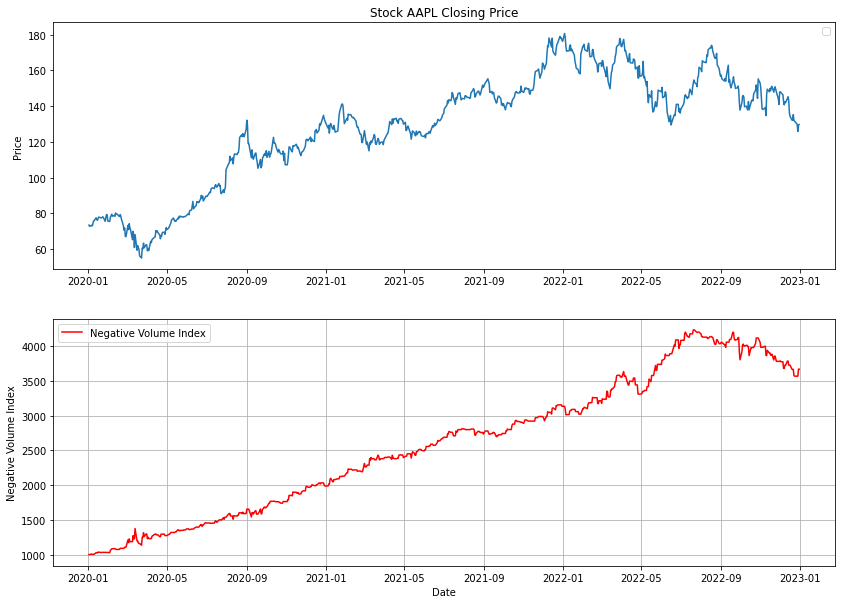

In [5]:
fig = plt.figure(figsize=(14,10))
ax1 = plt.subplot(2, 1, 1)
ax1.plot(df['Adj Close'])
ax1.set_title('Stock '+ symbol +' Closing Price')
ax1.set_ylabel('Price')
ax1.legend(loc='best')

ax2 = plt.subplot(2, 1, 2)
ax2.plot(df['NVI'], label='Negative Volume Index', color='red')
ax2.grid()
ax2.legend(loc='best')
ax2.set_ylabel('Negative Volume Index')
ax2.set_xlabel('Date')

## Candlestick with Negative Volume Index

In [6]:
from matplotlib import dates as mdates
import datetime as dt

dfc = df.copy()
dfc['VolumePositive'] = dfc['Open'] < dfc['Adj Close']
#dfc = dfc.dropna()
dfc = dfc.reset_index()
dfc['Date'] = pd.to_datetime(dfc['Date'])
dfc['Date'] = dfc['Date'].apply(mdates.date2num)
dfc.head()

,Date,Open,High,Low,Close,Adj Close,Volume,NVI,VolumePositive
0,18263.208333,74.059998,75.150002,73.797501,75.087502,73.449394,135480400,1000.000000,False
1,18264.208333,74.287498,75.144997,74.125000,74.357498,72.735321,146322800,1000.000000,False
2,18267.208333,73.447502,74.989998,73.187500,74.949997,73.314888,118387200,1007.968164,False
3,18268.208333,74.959999,75.224998,74.370003,74.597504,72.970100,108872000,1003.227859,False
4,18269.208333,74.290001,76.110001,74.290001,75.797501,74.143890,132079200,1003.227859,False


Text(0.5, 0, 'Date')

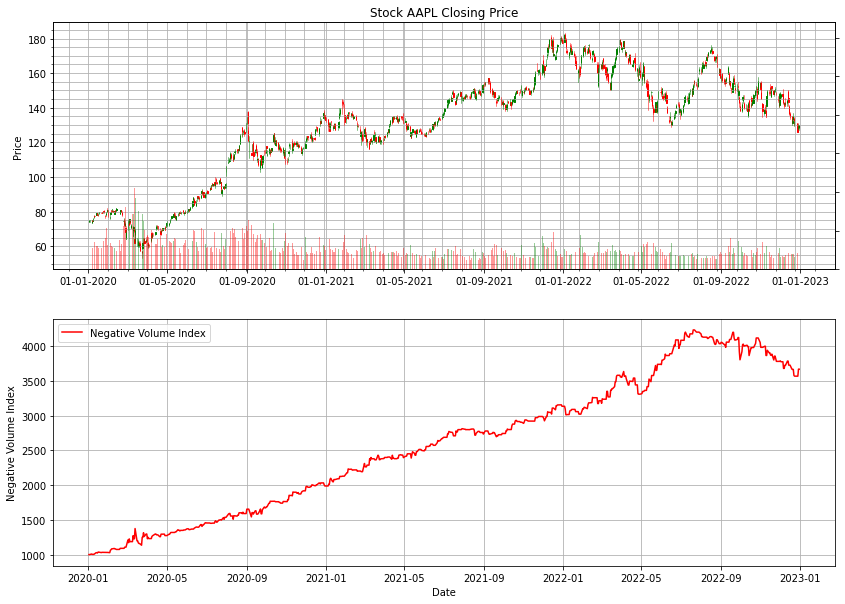

In [8]:
from mpl_finance import candlestick_ohlc

fig = plt.figure(figsize=(14,10))
ax1 = plt.subplot(2, 1, 1)
candlestick_ohlc(ax1,dfc.values, width=0.5, colorup='g', colordown='r', alpha=1.0)
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax1.grid(True, which='both')
ax1.minorticks_on()
ax1v = ax1.twinx()
colors = dfc.VolumePositive.map({True: 'g', False: 'r'})
ax1v.bar(dfc.Date, dfc['Volume'], color=colors, alpha=0.4)
ax1v.axes.yaxis.set_ticklabels([])
ax1v.set_ylim(0, 3*df.Volume.max())
ax1.set_title('Stock '+ symbol +' Closing Price')
ax1.set_ylabel('Price')

ax2 = plt.subplot(2, 1, 2)
ax2.plot(df['NVI'], label='Negative Volume Index', color='red')
ax2.grid()
ax2.legend(loc='best')
ax2.set_ylabel('Negative Volume Index')
ax2.set_xlabel('Date')